Loading epoch data for all subjects...
Extracting EDF parameters from /kaggle/input/bci-competition-2008-graz-data-set-b/BCICIV_2b_gdf/B0101T.gdf...
GDF file detected
Setting channel info structure...
Could not determine channel type of the following channels, they will be set as EEG:
EEG:C3, EEG:Cz, EEG:C4, EOG:ch01, EOG:ch02, EOG:ch03
Creating raw.info structure...
Reading 0 ... 604802  =      0.000 ...  2419.208 secs...
Extracting EDF parameters from /kaggle/input/bci-competition-2008-graz-data-set-b/BCICIV_2b_gdf/B0102T.gdf...
GDF file detected
Setting channel info structure...
Could not determine channel type of the following channels, they will be set as EEG:
EEG:C3, EEG:Cz, EEG:C4, EOG:ch01, EOG:ch02, EOG:ch03
Creating raw.info structure...
Reading 0 ... 552451  =      0.000 ...  2209.804 secs...
Extracting EDF parameters from /kaggle/input/bci-competition-2008-graz-data-set-b/BCICIV_2b_gdf/B0103T.gdf...
GDF file detected
Setting channel info structure...
Could not determine cha

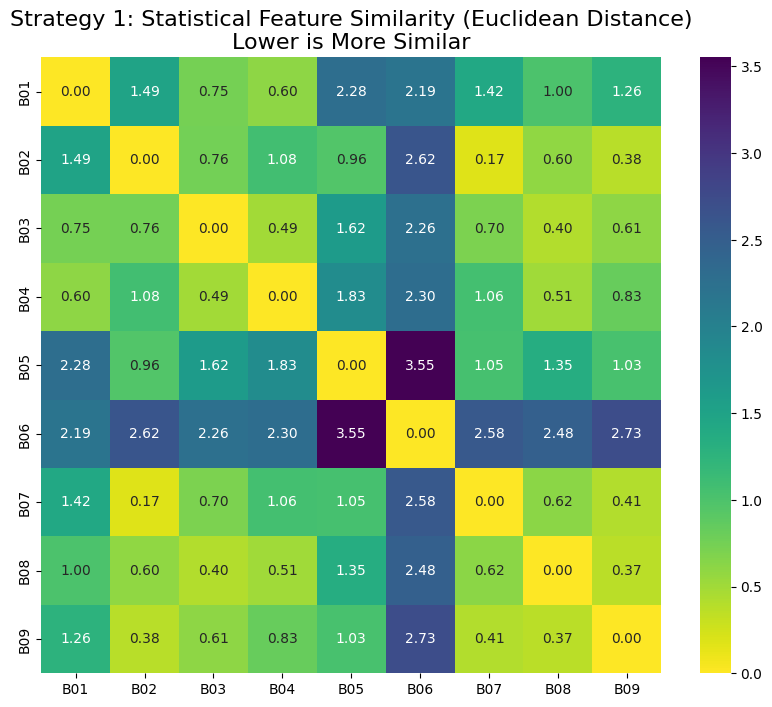


--- Automated Analysis Report ---
Analysis Type: Distance
Average between-subject distance: 1.287 (Std Dev: 0.840)
-----------------------------------
Most similar pair of distinct subjects: (B02, B07)
Their Distance: 0.167
This is the lowest distance, 1.33 standard deviations below the average.
Conclusion: The similarity is within the expected range for distinct subjects. No anomaly detected.
---------------------------------



Running Strategy 2: Power Spectral Density Analysis...
Effective window size : 4.004 (s)
Effective window size : 4.004 (s)
Effective window size : 4.004 (s)
Effective window size : 4.004 (s)
Effective window size : 4.004 (s)
Effective window size : 4.004 (s)
Effective window size : 4.004 (s)
Effective window size : 4.004 (s)
Effective window size : 4.004 (s)


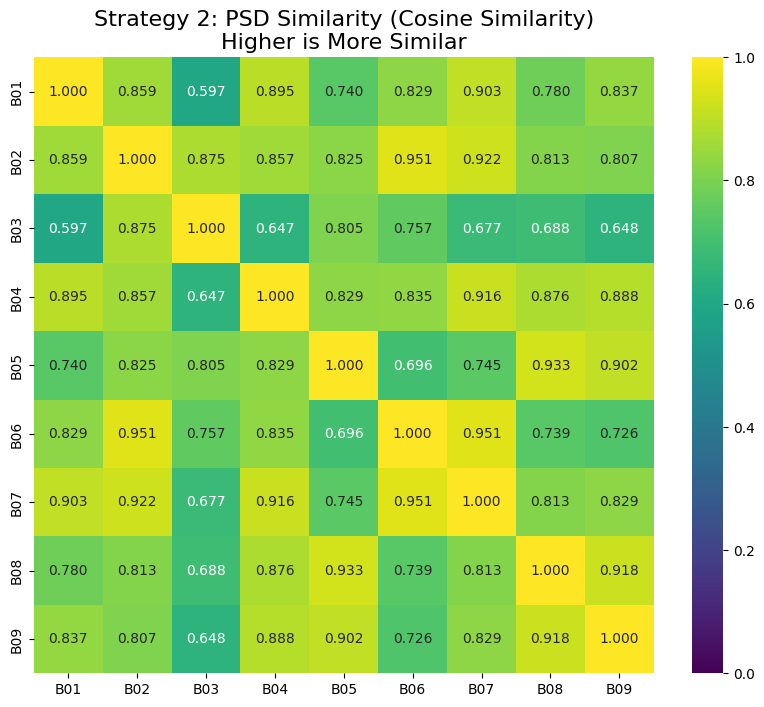


--- Automated Analysis Report ---
Analysis Type: Similarity
Average between-subject similarity: 0.814 (Std Dev: 0.092)
-----------------------------------
Most similar pair of distinct subjects: (B06, B07)
Their Similarity: 0.951
This is the highest similarity, 1.49 standard deviations above the average.
Conclusion: The similarity is within the expected range for distinct subjects. No anomaly detected.
---------------------------------



Running Strategy 3: Dynamic Time Warping Analysis...


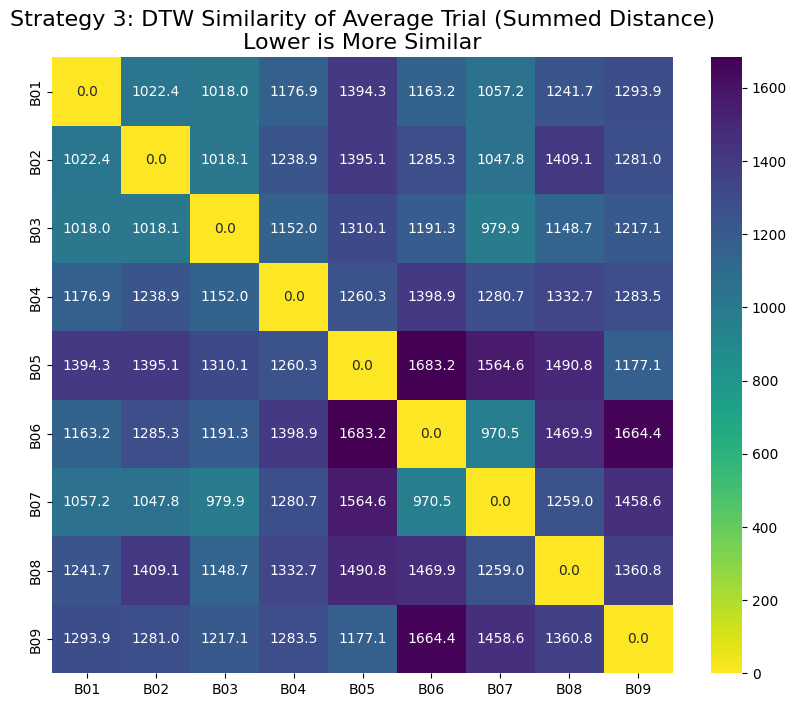


--- Automated Analysis Report ---
Analysis Type: Distance
Average between-subject distance: 1269.366 (Std Dev: 178.313)
-----------------------------------
Most similar pair of distinct subjects: (B06, B07)
Their Distance: 970.461
This is the lowest distance, 1.68 standard deviations below the average.
Conclusion: The similarity is within the expected range for distinct subjects. No anomaly detected.
---------------------------------



In [8]:
# -*- coding: utf-8 -*-
"""
This script performs a subject-uniqueness analysis on the BCI Competition 2008
Graz data set B using three different strategies:
1.  Statistical Analysis: Compares basic statistical features of the EEG signals.
2.  Power Spectral Density (PSD): Compares the "brain fingerprint" based on frequency power.
3.  Dynamic Time Warping (DTW): Compares the temporal shape of the average EEG response.

The goal is to verify that the 9 subjects in the dataset are indeed unique individuals.
This version includes an automated report for each analysis method.
"""

import os
import warnings
from pathlib import Path
import mne
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from scipy.stats import skew, kurtosis
from scipy.spatial.distance import pdist, squareform
from sklearn.metrics.pairwise import cosine_similarity
from dtw import dtw

# Suppress warnings for cleaner output
warnings.filterwarnings('ignore', category=RuntimeWarning)
warnings.filterwarnings('ignore', category=FutureWarning)

# --- 1. SETUP: Define data path and parameters ---

DATA_DIR = Path("/kaggle/input/bci-competition-2008-graz-data-set-b/BCICIV_2b_gdf") 
NUM_SUBJECTS = 9
SESSIONS_PER_SUBJECT = ['01T', '02T', '03T'] 
T_MIN, T_MAX = 3.0, 7.0 
EEG_CHANNELS = ['EEG:C3', 'EEG:Cz', 'EEG:C4'] 


# --- 2. REPORTING FUNCTION ---

def generate_report(matrix, labels, is_distance=False):
    """
    Analyzes a similarity/distance matrix and generates a textual report.

    Args:
        matrix (np.ndarray): The square similarity or distance matrix.
        labels (list): The list of subject labels corresponding to the matrix axes.
        is_distance (bool): True if the matrix represents distance (lower is more similar),
                            False if it represents similarity (higher is more similar).

    Returns:
        str: A formatted string containing the analysis report.
    """
    if matrix.shape[0] != matrix.shape[1] or matrix.shape[0] != len(labels):
        return "Error: Matrix dimensions do not match the number of labels."

    # Get off-diagonal values (where i != j) for baseline comparison
    off_diagonal_mask = ~np.eye(matrix.shape[0], dtype=bool)
    off_diagonal_values = matrix[off_diagonal_mask]

    if len(off_diagonal_values) == 0:
        return "Report: Not enough data for a comparative report."

    # Calculate statistics for between-subject comparisons
    mean_off_diag = np.mean(off_diagonal_values)
    std_off_diag = np.std(off_diagonal_values)

    # Find the most similar pair of *distinct* subjects
    # To do this, temporarily fill the diagonal with a value that won't be selected
    temp_matrix = matrix.copy()
    if is_distance:
        np.fill_diagonal(temp_matrix, np.inf)
        most_similar_pair_idx = np.unravel_index(np.argmin(temp_matrix, axis=None), temp_matrix.shape)
        metric_name = "distance"
        comparison_word = "lowest"
    else: # is_similarity
        np.fill_diagonal(temp_matrix, -np.inf)
        most_similar_pair_idx = np.unravel_index(np.argmax(temp_matrix, axis=None), temp_matrix.shape)
        metric_name = "similarity"
        comparison_word = "highest"

    i, j = most_similar_pair_idx
    most_similar_pair_value = matrix[i, j]
    
    # Calculate the Z-score to quantify how anomalous the finding is
    if std_off_diag > 1e-9: # Avoid division by zero
        z_score = (most_similar_pair_value - mean_off_diag) / std_off_diag
    else:
        z_score = 0

    # Build the report string
    report = f"\n--- Automated Analysis Report ---\n"
    report += f"Analysis Type: {metric_name.title()}\n"
    report += f"Average between-subject {metric_name}: {mean_off_diag:.3f} (Std Dev: {std_off_diag:.3f})\n"
    report += "-"*35 + "\n"
    report += f"Most similar pair of distinct subjects: ({labels[i]}, {labels[j]})\n"
    report += f"Their {metric_name.title()}: {most_similar_pair_value:.3f}\n"

    # Interpret the Z-score
    if is_distance:
        report += f"This is the {comparison_word} distance, {abs(z_score):.2f} standard deviations below the average.\n"
    else:
        report += f"This is the {comparison_word} similarity, {z_score:.2f} standard deviations above the average.\n"

    # Conclusion based on Z-score threshold
    conclusion = "Conclusion: The similarity is within the expected range for distinct subjects. No anomaly detected."
    if abs(z_score) > 2.5:
        conclusion = f"Conclusion: STRONG ANOMALY DETECTED. The similarity between {labels[i]} and {labels[j]} is exceptionally high, warranting further investigation."
    elif abs(z_score) > 1.8:
        conclusion = f"Conclusion: POTENTIAL ANOMALY. The similarity between {labels[i]} and {labels[j]} is notably higher than average."

    report += conclusion
    report += f"\n---------------------------------\n"
    return report


# --- 3. DATA LOADING FUNCTION ---

def load_subject_epochs(subject_id: int) -> tuple[str, mne.Epochs] | None:
    """Loads all specified training sessions for a single subject."""
    subject_str = f"B{subject_id:02d}"
    session_files = [DATA_DIR / f"{subject_str}{session}.gdf" for session in SESSIONS_PER_SUBJECT]
    
    session_files = [f for f in session_files if f.exists()]
    if not session_files:
        print(f"Info: No data files found for subject {subject_str}. Skipping.")
        return None

    raw_list = []
    for f in session_files:
        raw = mne.io.read_raw_gdf(f, preload=True)
        raw_list.append(raw)
        
    raw_all = mne.concatenate_raws(raw_list)
    raw_all.pick(EEG_CHANNELS)
    
    try:
        events, event_dict = mne.events_from_annotations(raw_all)
    except ValueError:
        print(f"Info: Could not find any annotations for subject {subject_str}. Skipping.")
        return None

    event_id_for_epochs = {}
    if '769' in event_dict: event_id_for_epochs['left_hand'] = event_dict['769']
    if '770' in event_dict: event_id_for_epochs['right_hand'] = event_dict['770']

    if not event_id_for_epochs:
        print(f"Info: Could not find MI event markers (769, 770) for subject {subject_str}. Skipping.")
        return None
        
    epochs = mne.Epochs(raw_all, events, event_id=event_id_for_epochs, tmin=T_MIN, tmax=T_MAX,
                        proj=False, baseline=None, preload=True, on_missing='warn')
    
    if len(epochs) == 0:
        print(f"Warning: Found 0 valid trials for Subject {subject_id:02d} after epoching.")
        return None
    
    print(f"Successfully loaded {len(epochs)} trials for Subject {subject_str} from {len(session_files)} files.")
    return subject_str, epochs


# --- 4. MAIN SCRIPT ---

print("Loading epoch data for all subjects...")
loaded_data = [load_subject_epochs(i) for i in range(1, NUM_SUBJECTS + 1)]
loaded_data = [data for data in loaded_data if data is not None]

if len(loaded_data) < 2:
    raise RuntimeError(
        f"CRITICAL: Loaded data for only {len(loaded_data)} subject(s). "
        "Cannot perform a comparative analysis. Please check file paths and data integrity."
    )

subject_labels, all_subject_epochs = zip(*loaded_data)
print(f"\nSuccessfully loaded data for {len(all_subject_epochs)} subjects: {', '.join(subject_labels)}")
print("\n" + "="*50 + "\n")


# --- 5. STRATEGY 1: STATISTICAL ANALYSIS ---

print("Running Strategy 1: Statistical Feature Analysis...")
stat_features = []
for epochs in all_subject_epochs:
    data = epochs.get_data()
    subject_feature_vector = []
    for i in range(data.shape[1]):
        channel_data = data[:, i, :]
        mean_val, var_val = np.mean(np.mean(channel_data, axis=1)), np.mean(np.var(channel_data, axis=1))
        skew_val, kurt_val = np.mean(skew(channel_data, axis=1)), np.mean(kurtosis(channel_data, axis=1))
        subject_feature_vector.extend([mean_val, var_val, skew_val, kurt_val])
    stat_features.append(subject_feature_vector)

stat_features_np = np.array(stat_features)
stat_distance_matrix = squareform(pdist(stat_features_np, 'euclidean'))

plt.figure(figsize=(10, 8))
sns.heatmap(stat_distance_matrix, annot=True, fmt='.2f', cmap='viridis_r', 
            xticklabels=subject_labels, yticklabels=subject_labels)
plt.title('Strategy 1: Statistical Feature Similarity (Euclidean Distance)\nLower is More Similar', fontsize=16)
plt.show()
print(generate_report(stat_distance_matrix, subject_labels, is_distance=True))
print("\n" + "="*50 + "\n")


# --- 6. STRATEGY 2: POWER SPECTRAL DENSITY (PSD) ---

print("Running Strategy 2: Power Spectral Density Analysis...")
psd_features = []
for epochs in all_subject_epochs:
    psd = epochs.compute_psd(method='welch', fmin=1.0, fmax=40.0, picks='eeg')
    avg_psd = psd.get_data().mean(axis=0)
    psd_features.append(avg_psd.flatten())

psd_similarity_matrix = cosine_similarity(psd_features)

plt.figure(figsize=(10, 8))
sns.heatmap(psd_similarity_matrix, annot=True, fmt='.3f', cmap='viridis', vmin=0, vmax=1,
            xticklabels=subject_labels, yticklabels=subject_labels)
plt.title('Strategy 2: PSD Similarity (Cosine Similarity)\nHigher is More Similar', fontsize=16)
plt.show()
print(generate_report(psd_similarity_matrix, subject_labels, is_distance=False))
print("\n" + "="*50 + "\n")


# --- 7. STRATEGY 3: DYNAMIC TIME WARPING (DTW) ---

print("Running Strategy 3: Dynamic Time Warping Analysis...")
subject_evokeds = [epochs.average() for epochs in all_subject_epochs]
dtw_distance_matrix = np.zeros((len(subject_evokeds), len(subject_evokeds)))

for i in range(len(subject_evokeds)):
    for j in range(i, len(subject_evokeds)):
        total_dist = 0
        for ch_idx in range(len(EEG_CHANNELS)):
            waveform1, waveform2 = subject_evokeds[i].data[ch_idx], subject_evokeds[j].data[ch_idx]
            waveform1, waveform2 = (waveform1 - waveform1.mean()) / waveform1.std(), (waveform2 - waveform2.mean()) / waveform2.std()
            dist = dtw(waveform1, waveform2, keep_internals=False).distance
            total_dist += dist
        dtw_distance_matrix[i, j], dtw_distance_matrix[j, i] = total_dist, total_dist

plt.figure(figsize=(10, 8))
sns.heatmap(dtw_distance_matrix, annot=True, fmt='.1f', cmap='viridis_r',
            xticklabels=subject_labels, yticklabels=subject_labels)
plt.title('Strategy 3: DTW Similarity of Average Trial (Summed Distance)\nLower is More Similar', fontsize=16)
plt.show()
print(generate_report(dtw_distance_matrix, subject_labels, is_distance=True))

--- BCI Competition 2008 Subject Verification Script ---
Using dataset from: ../input/bci-competition-2008-graz-data-set-b/BCICIV_2b_gdf/

Step 1: Extracting features and creating a stable template for each subject...
  - Processing Subject: B01
Extracting EDF parameters from /kaggle/input/bci-competition-2008-graz-data-set-b/BCICIV_2b_gdf/B0101T.gdf...
GDF file detected
Setting channel info structure...
Could not determine channel type of the following channels, they will be set as EEG:
EEG:C3, EEG:Cz, EEG:C4, EOG:ch01, EOG:ch02, EOG:ch03
Creating raw.info structure...
Reading 0 ... 604802  =      0.000 ...  2419.208 secs...
Used Annotations descriptions: ['1023', '1077', '1078', '1079', '1081', '276', '277', '32766', '768', '769', '770']
Extracting EDF parameters from /kaggle/input/bci-competition-2008-graz-data-set-b/BCICIV_2b_gdf/B0102T.gdf...
GDF file detected
Setting channel info structure...
Could not determine channel type of the following channels, they will be set as EEG:
EEG

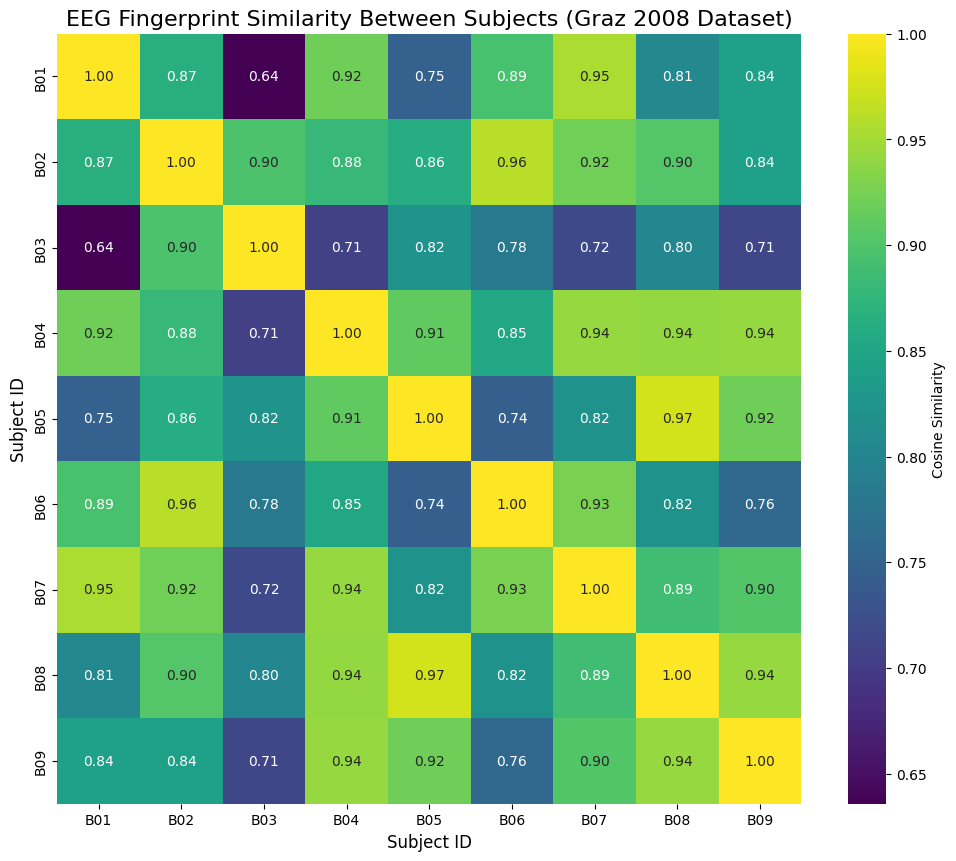


--- Script Finished ---


In [1]:
import pandas as pd
import numpy as np
import os
import mne
from scipy.signal import welch
from sklearn.metrics.pairwise import cosine_similarity
import matplotlib.pyplot as plt
import seaborn as sns
import warnings

# Suppress MNE and other warnings for cleaner output
warnings.filterwarnings("ignore", category=RuntimeWarning)
warnings.filterwarnings("ignore", category=FutureWarning)

print("--- BCI Competition 2008 Subject Verification Script ---")

# --- 1. Configuration & Setup ---
# Set the base path to the dataset directory in Kaggle
BASE_PATH = '../input/bci-competition-2008-graz-data-set-b/BCICIV_2b_gdf/'

# Check if the directory exists
if not os.path.exists(BASE_PATH):
    raise FileNotFoundError("Dataset directory not found. Please check the BASE_PATH variable.")

print(f"Using dataset from: {BASE_PATH}")

# Dataset Parameters
SUBJECT_IDS = [f'B0{i}' for i in range(1, 10)]
TRAINING_SESSIONS = ['01T', '02T', '03T']
SAMPLING_RATE = 250  # Hz
EEG_CHANNEL_COUNT = 3  # C3, Cz, C4 are the first 3 channels

# We will use the 1.5-second period before each trial starts as the rest period
REST_DURATION = 1.5  # seconds
REST_SAMPLES = int(REST_DURATION * SAMPLING_RATE)
TRIAL_START_EVENT_ID = '768' # Event ID for "Start of a trial"

# --- 2. Feature Extraction Function ---

def extract_psd_features(data_segment):
    """Extracts PSD features from an EEG data segment."""
    # Calculate PSD using Welch's method for each of the 3 EEG channels
    # nperseg defines the window for FFT, affecting frequency resolution
    freqs, psd = welch(data_segment, fs=SAMPLING_RATE, axis=1, nperseg=128)
    
    # Flatten the PSDs from all channels into a single feature vector
    return psd.flatten()

# --- 3. Main Processing: Feature Extraction and Template Creation ---

subject_templates = {}
print("\nStep 1: Extracting features and creating a stable template for each subject...")

for subject_id in SUBJECT_IDS:
    print(f"  - Processing Subject: {subject_id}")
    
    # Store features for all trials of this subject across all sessions
    all_subject_features = []
    
    for session_id in TRAINING_SESSIONS:
        file_name = f'{subject_id}{session_id}.gdf'
        file_path = os.path.join(BASE_PATH, file_name)
        
        if not os.path.exists(file_path):
            print(f"    - Warning: File {file_name} not found. Skipping.")
            continue
            
        try:
            # Load the GDF file using MNE-Python, preload data into memory
            raw = mne.io.read_raw_gdf(file_path, preload=True)
            
            # Get events from annotations. MNE reads event IDs as strings.
            events, event_dict = mne.events_from_annotations(raw)
            
            # Find the sample positions of all "start of trial" events
            start_trial_positions = events[events[:, 2] == event_dict[TRIAL_START_EVENT_ID]][:, 0]
            
            # We extract the rest period *before* each trial starts.
            # We skip the very first trial as it has no preceding data in this context.
            for pos in start_trial_positions[1:]:
                start_sample = pos - REST_SAMPLES
                end_sample = pos
                
                if start_sample < 0:
                    continue # Should not happen after skipping the first trial, but good practice
                
                # Get the 3 EEG channels for the rest segment
                rest_data_segment = raw.get_data(picks=range(EEG_CHANNEL_COUNT), start=start_sample, stop=end_sample)
                
                # Extract features and add to our list
                psd_features = extract_psd_features(rest_data_segment)
                all_subject_features.append(psd_features)

        except Exception as e:
            print(f"    - Error processing file {file_name}: {e}")
            continue
            
    # Create the averaged template by taking the mean of all trial features for the subject
    if all_subject_features:
        subject_template = np.mean(all_subject_features, axis=0)
        subject_templates[subject_id] = subject_template

print("\nAll subject templates created successfully.")

# --- 4. Similarity Analysis ---
print("\nStep 2: Calculating similarity between all subject templates...")

if not subject_templates:
    print("No subject templates were created. Cannot perform analysis.")
else:
    # Prepare data for similarity calculation
    template_labels = list(subject_templates.keys())
    template_vectors = list(subject_templates.values())

    # Calculate the cosine similarity matrix
    similarity_matrix = cosine_similarity(template_vectors)
    similarity_df = pd.DataFrame(similarity_matrix, index=template_labels, columns=template_labels)

    # --- 5. Diagnostics ---
    print("\n--- DIAGNOSTIC RESULTS ---")

    similarity_off_diagonal = similarity_df.copy()
    np.fill_diagonal(similarity_off_diagonal.values, np.nan)

    off_diagonal_values = similarity_off_diagonal.values[~np.isnan(similarity_off_diagonal.values)]
    mean_similarity = np.mean(off_diagonal_values)
    std_similarity = np.std(off_diagonal_values)
    max_similarity = np.max(off_diagonal_values) if not np.isnan(off_diagonal_values).all() else 0.0

    print(f"\nOff-Diagonal Similarity Statistics:")
    print(f"  - Mean Similarity between different subjects: {mean_similarity:.4f}")
    print(f"  - Std Dev of Similarity: {std_similarity:.4f}")
    print(f"  - Maximum Similarity found between two different subjects: {max_similarity:.4f}")

    if max_similarity > 0:
        most_similar_pairs = similarity_off_diagonal.stack().idxmax()
        print(f"\nMost Similar Pair of Different Subjects: {most_similar_pairs} with a score of {max_similarity:.4f}")

    # --- 6. High-Similarity Pair Report ---
    print("\n--- High-Similarity Pairs Report (Similarity > 0.9) ---")
    HIGH_SIMILARITY_THRESHOLD = 0.9
    
    high_similarity_pairs = similarity_off_diagonal[similarity_off_diagonal > HIGH_SIMILARITY_THRESHOLD].stack().reset_index()
    if not high_similarity_pairs.empty:
        high_similarity_pairs.columns = ['Subject_1', 'Subject_2', 'Similarity']
        high_similarity_pairs['sorted_subjects'] = high_similarity_pairs.apply(lambda row: tuple(sorted((row['Subject_1'], row['Subject_2']))), axis=1)
        unique_high_similarity_pairs = high_similarity_pairs.drop_duplicates(subset='sorted_subjects').reset_index(drop=True)
        
        if not unique_high_similarity_pairs.empty:
            print(f"Found {len(unique_high_similarity_pairs)} unique pair(s) with similarity > {HIGH_SIMILARITY_THRESHOLD}:")
            for index, row in unique_high_similarity_pairs.iterrows():
                print(f"  - Pair: ({row['Subject_1']}, {row['Subject_2']}), Similarity: {row['Similarity']:.4f}")
        else:
             print(f"No pairs found with similarity greater than {HIGH_SIMILARITY_THRESHOLD}.")
    else:
        print(f"No pairs found with similarity greater than {HIGH_SIMILARITY_THRESHOLD}.")

    # --- 7. Visualization ---
    print("\nGenerating similarity matrix heatmap...")
    plt.figure(figsize=(12, 10))
    sns.heatmap(similarity_df, annot=True, fmt=".2f", cmap="viridis", cbar_kws={'label': 'Cosine Similarity'})
    plt.title('EEG Fingerprint Similarity Between Subjects (Graz 2008 Dataset)', fontsize=16)
    plt.xlabel('Subject ID', fontsize=12)
    plt.ylabel('Subject ID', fontsize=12)
    plt.show()

print("\n--- Script Finished ---")